# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1606321589612_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

  Usi

## Importing

Now, import the installed packages from the previous block below.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode,split

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json('s3://project02-jason/yelp_academic_dataset_business.json')
review = spark.read.json('s3://project02-jason/yelp_academic_dataset_review.json')
user = spark.read.json('s3://project02-jason/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [4]:
bs = business.toPandas()
print("Columns: " + str(bs.shape[1]) + " | " + "Rows: " + str(len(bs)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209393

Display the DataFrame schema below.

In [5]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [6]:
business.select("business_id","name","city","state","stars","categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+-----+--------------------+
|         business_id|                name|           city|state|stars|          categories|
+--------------------+--------------------+---------------+-----+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|  3.5|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|  5.0|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|  5.0|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|  2.5|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|  4.5|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [7]:
df=business.withColumn('newcategories',explode(split('categories',", ")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [8]:
df.select("business_id","newcategories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|   newcategories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [9]:
df.select("newcategories").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [10]:
df.groupby("newcategories").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|       newcategories|count|
+--------------------+-----+
|      Dermatologists|  341|
|      Paddleboarding|   36|
|        Aerial Tours|   28|
|         Hobby Shops|  828|
|          Bubble Tea|  720|
|             Embassy|   13|
|            Handyman|  682|
|             Tanning|  938|
|      Aerial Fitness|   29|
|             Tempura|    1|
|             Falafel|  159|
|       Outlet Stores|  399|
|        Summer Camps|  318|
|     Clothing Rental|   55|
|      Sporting Goods| 2311|
|     Cooking Schools|  118|
|  College Counseling|   15|
|  Lactation Services|   50|
|Ski & Snowboard S...|   50|
|             Museums|  359|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [11]:
barchart_df=df.groupby("newcategories").count().orderBy('count',ascending=False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
pdf = barchart_df.toPandas()
pdf=pdf.head(20)
pdf_sort= pdf.sort_values('count')
plt.figure(figsize=(10,6))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Figure size 1000x600 with 0 Axes>

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

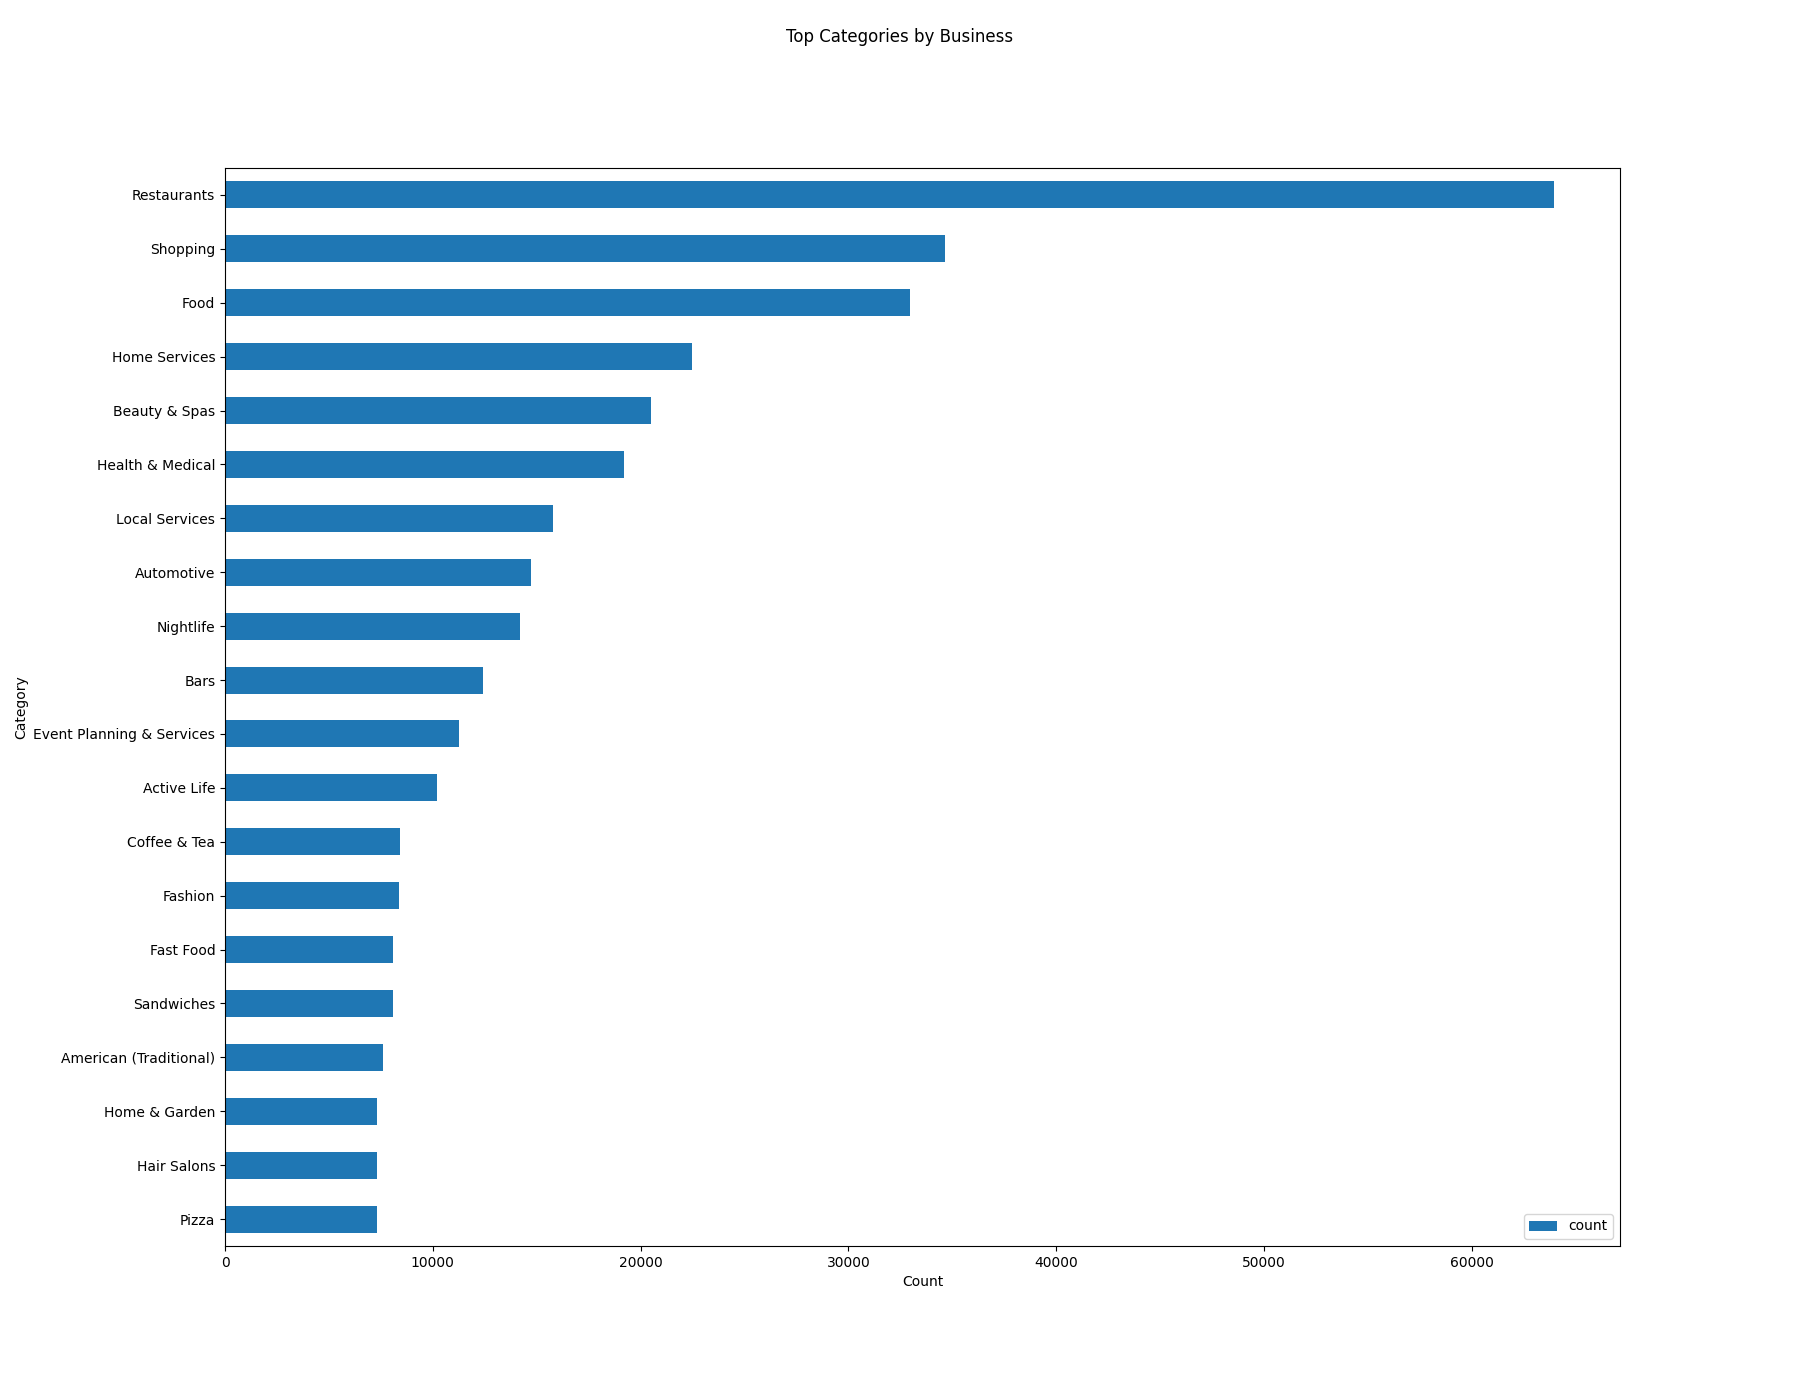

In [13]:
pdf_sort.plot(kind='barh',x='newcategories',figsize=(18,14))
plt.suptitle('Top Categories by Business')
plt.xlabel("Count")
plt.ylabel("Category")
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [14]:
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [15]:
bus_avgstars=review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [16]:
bus_avgstars=review.select('business_id','stars').groupby('business_id').mean()
bus_avgstars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|kpbhERZoj1eTDRnMV...| 2.033333333333333|
|ipFreSFhjClfNETuM...|               2.6|
|9A_mB7Ez3RIh26EN5...|               2.6|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [17]:
bus_stars=business.select("stars","business_id","name","city","state")
bus_stars_avgstars=bus_avgstars.join(bus_stars,bus_stars.business_id==bus_avgstars.business_id)
bus_stars_avgstars=bus_stars_avgstars.drop(bus_stars_avgstars.columns[0])
bus_stars_avgstars=bus_stars_avgstars.orderBy('avg(stars)',ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [18]:
bus_stars_avgstars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+----------------+-----+
|avg(stars)|stars|                name|            city|state|
+----------+-----+--------------------+----------------+-----+
|       5.0|  5.0|         Sasha Lopez|           Tempe|   AZ|
|       5.0|  5.0|Dankle Brunson & ...|       Champaign|   IL|
|       5.0|  5.0|    Pcshop Computers|         Toronto|   ON|
|       5.0|  5.0|Andre Agassi Coll...|       Las Vegas|   NV|
|       5.0|  5.0|Gem-Crafters Jewe...|Mayfield Heights|   OH|
+----------+-----+--------------------+----------------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [19]:
bus_skew=bus_stars_avgstars.withColumn('skew', ((bus_stars_avgstars['avg(stars)']-bus_stars_avgstars['stars'])/bus_stars_avgstars['stars']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

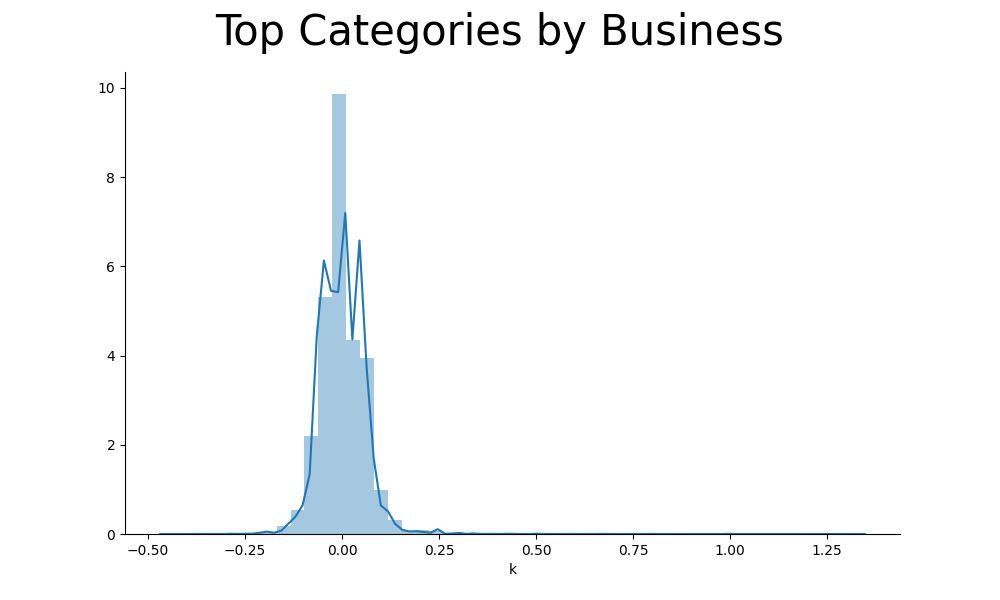

In [20]:
plt.cla()
bus_skew_pd=bus_skew.toPandas()
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(bus_skew_pd['skew'],ax=ax)
plt.suptitle('Top Categories by Business',fontsize=30)
sns.despine()
plt.xlabel("k")
%matplot plt


So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

Yes, Yelp Reviews skew negtive, from the graph, it is very obvious to see that as of mid point 0 on x-axis, The left shaded blue area is a lot bigger than the right. This means when we use rating of people who wrote review mins actual rating, it is more likely to get a negtive value which means those people who wrote review are likely rated lower.



# Extra Work for part 3

For better understanding, I counted the total number of positive skew and total number of negtive skew. Negative is 80982 and positive is 77821 which means the people who write review are more likely rate lower than the actual rating.

In [36]:
bus_skew_negative=bus_skew[bus_skew.skew<0].count()
bus_skew_positive=bus_skew[bus_skew.skew>0].count()
d = {'negative': bus_skew_negative, 'positive': bus_skew_positive}
d

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'negative': 80982, 'positive': 77821}

I created a new dataframe with columns, average skew and the corresponding categories. I reorder them by average skew and showed the top 5.

In [22]:
bus_stars1=business.select("stars","business_id","name","city","state","categories")
bus_stars_avgstars1=bus_avgstars.join(bus_stars1,bus_stars1.business_id==bus_avgstars.business_id)
bus_stars_avgstars1=bus_stars_avgstars1.drop(bus_stars_avgstars1.columns[0])
bus_stars_avgstars1=bus_stars_avgstars1.orderBy('avg(stars)',ascending=False)
bus_skew1=bus_stars_avgstars1.withColumn('skew', ((bus_stars_avgstars1['avg(stars)']-bus_stars_avgstars1['stars'])/bus_stars_avgstars1['stars']))
bus_skew1_ca=bus_skew1.select("categories","skew").groupby("categories").mean()
bus_skew1_ca=bus_skew1_ca.orderBy('avg(skew)')
bus_skew1_ca.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|          categories|           avg(skew)|
+--------------------+--------------------+
|Real Estate, Apar...|-0.45454545454545453|
|Home Services, Re...| -0.3766233766233767|
|Hotels & Travel, ...| -0.3333333333333333|
|Auto Detailing, A...| -0.3230769230769231|
|Nightlife, Pubs, ...|-0.31428571428571433|
+--------------------+--------------------+
only showing top 5 rows

I graphed a bar plot to show how negatively the review writer rated these business and I ordered them by categories.By doing this graph, we can tell which categories of business are affected negatively by the users who wrote reviews the most.The Real Estate, apartments businesses are very likely to be low rated by those people who wrote reviews. The top 5 categores are The Real Estate, apartments business, Home Service business. Hotel & Travel business, Auto Detailing , Repaire business and Professional Services business.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

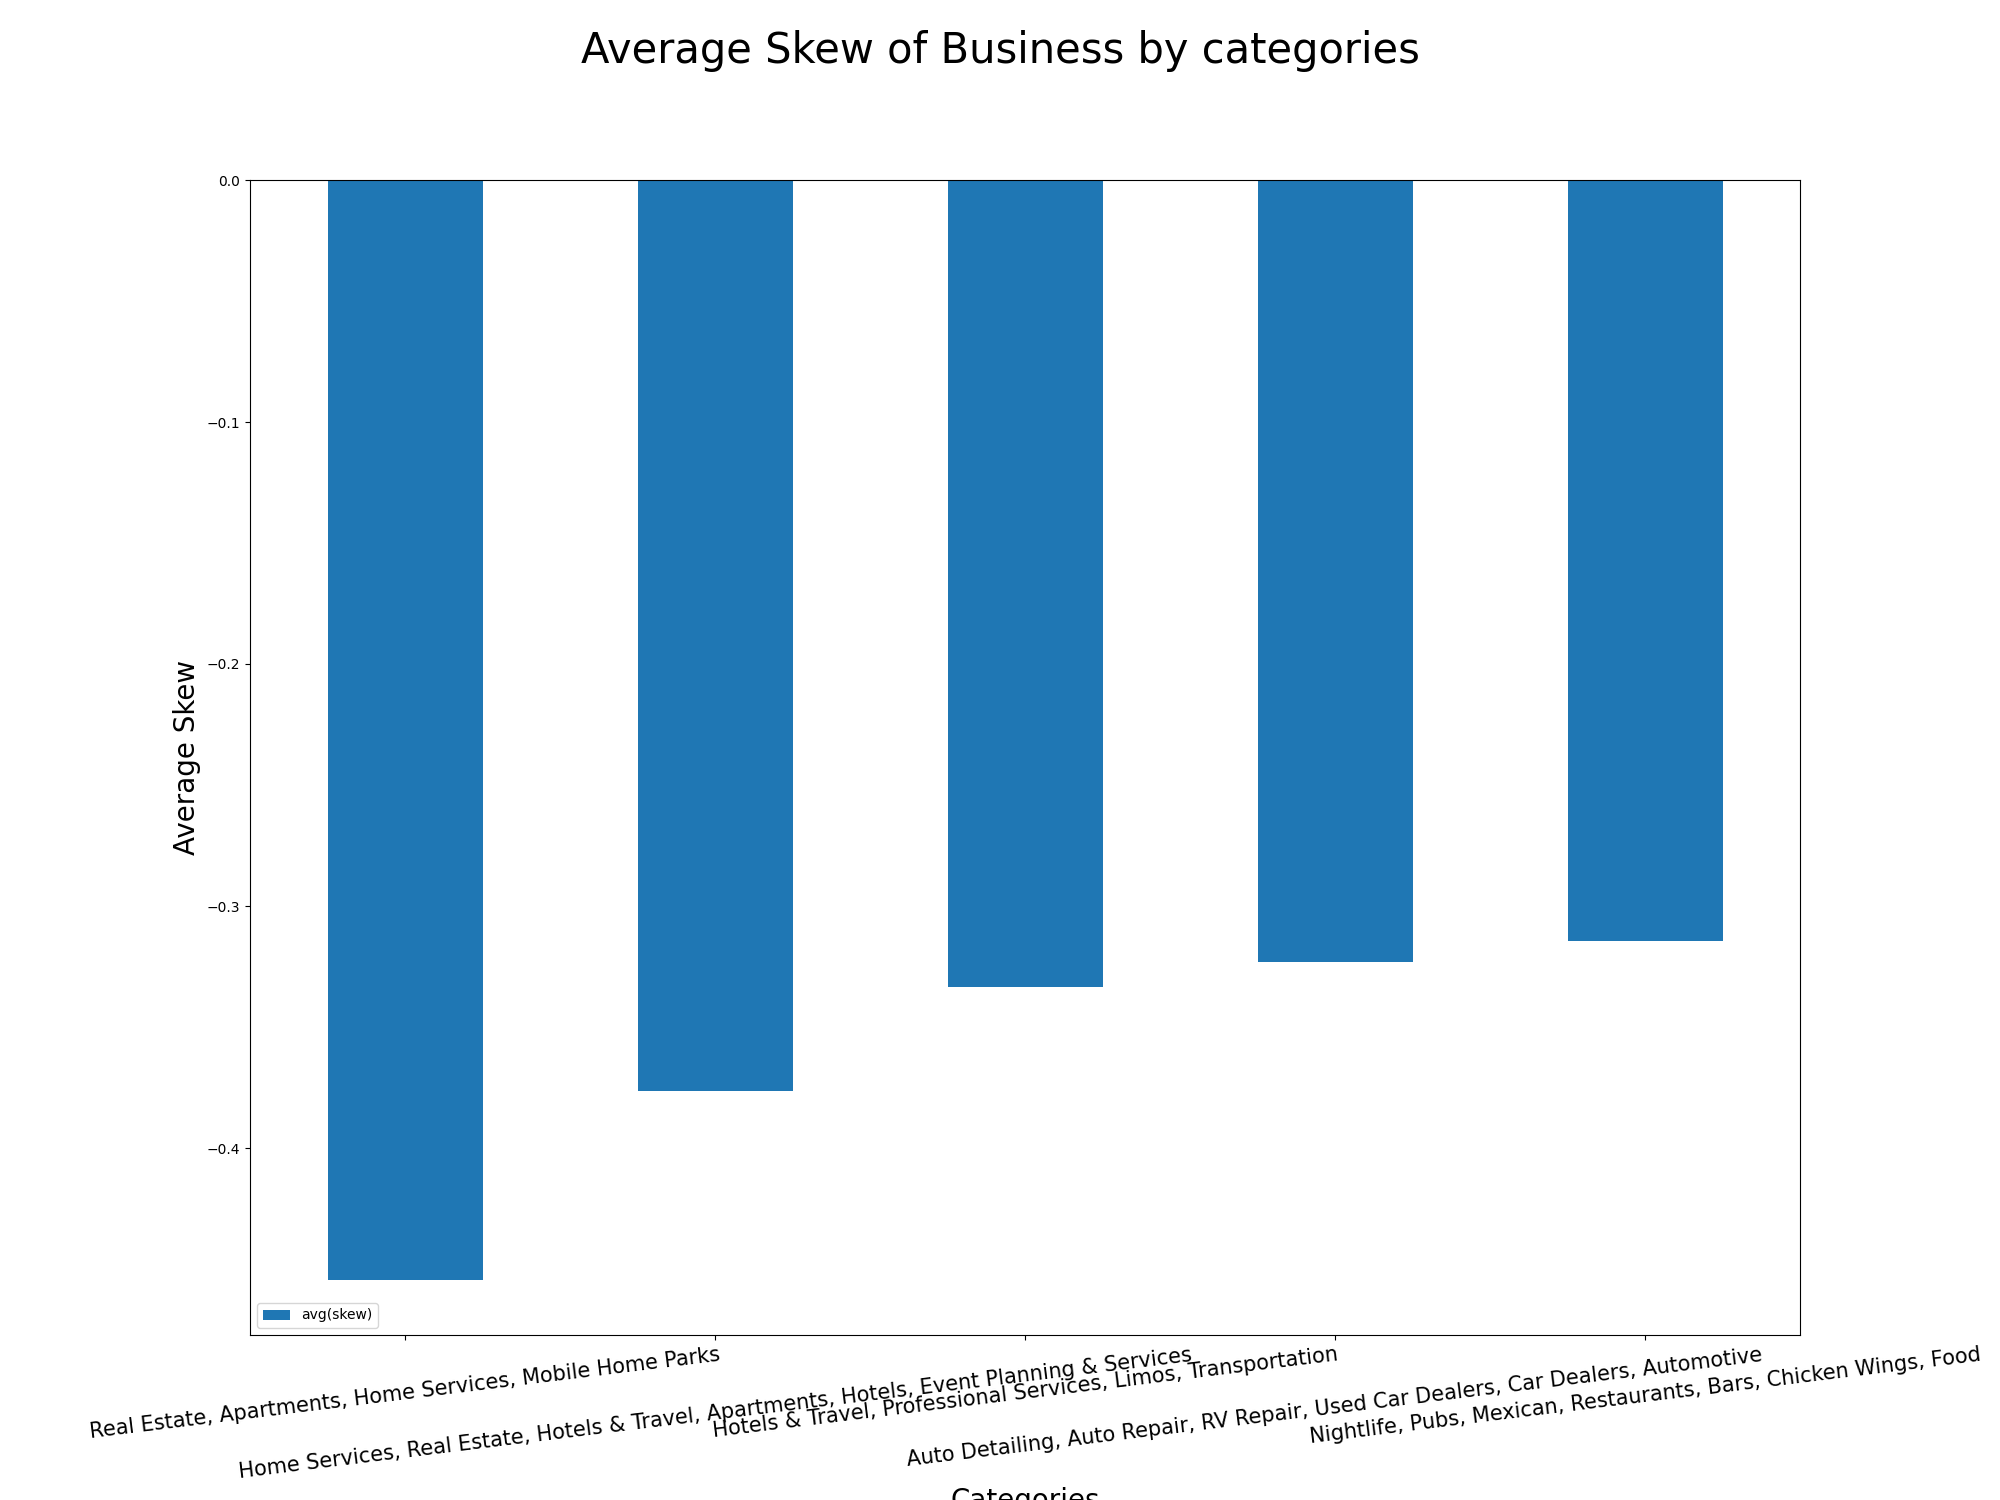

In [23]:
bus_skew1_caf = bus_skew1_ca.toPandas()
bus_skew1_caf=bus_skew1_caf.head(5)
bus_skew1_caf= bus_skew1_caf.sort_values('avg(skew)')
bus_skew1_caf.plot(kind='bar',x='categories',figsize=(20,15))
plt.suptitle('Average Skew of Business by categories',fontsize=30)
plt.xlabel("Categories",fontsize=20)
plt.ylabel("Average Skew",fontsize=20)
plt.xticks( rotation=7, fontsize=15)
%matplot plt

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

1. I used user table first and got rid off the users who are not elites and joined this table with review table that only contains user_id, business_id and stars. Thus I got a table that only contains reviewers who are elites. Then I aggregated elites average rating to the table for each business. Finally I join table with business table that contains actual stars, business name, city and state. 

In [35]:
user_elite=review.select("user_id","business_id","stars")
review_elite=user.select("user_id","elite")
review_elite=review_elite[review_elite.elite!=""]
user_elite_review=review_elite.join(user_elite,review_elite.user_id==user_elite.user_id)
user_elite_review=user_elite_review.drop(user_elite_review.columns[1])
user_elite_review=user_elite_review.groupby('business_id').mean()
user_elite_bus=user_elite_review.join(bus_stars,bus_stars.business_id==user_elite_review.business_id)
user_elite_bus=user_elite_bus.drop(user_elite_bus.columns[3])
user_elite_bus.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+---------+-----+
|        avg(stars)|stars|                name|     city|state|
+------------------+-----+--------------------+---------+-----+
|4.1916058394160585|  4.0|Delmonico Steakhouse|Las Vegas|   NV|
|               4.0|  4.0|Maricopa County D...|  Phoenix|   AZ|
|               4.0|  4.0|Double Play Sport...|Las Vegas|   NV|
|               5.0|  5.0|   Kidz Cuts By Lori|Henderson|   NV|
| 3.793103448275862|  4.0|Río Mirage Café y...|El Mirage|   AZ|
+------------------+-----+--------------------+---------+-----+
only showing top 5 rows

2. Just like what I did for the skew question, I added a skew column for this table as well. by doing so, if skew is very close to 0, we can tell if the elite reviewer's rating close to the actual rating.

In [37]:
elite_skew=user_elite_bus.withColumn('skew', ((user_elite_bus['avg(stars)']-user_elite_bus['stars'])/user_elite_bus['stars']))
elite_skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+---------+-----+--------------------+
|        avg(stars)|stars|                name|     city|state|                skew|
+------------------+-----+--------------------+---------+-----+--------------------+
|4.1916058394160585|  4.0|Delmonico Steakhouse|Las Vegas|   NV|0.047901459854014616|
|               4.0|  4.0|Maricopa County D...|  Phoenix|   AZ|                 0.0|
|               4.0|  4.0|Double Play Sport...|Las Vegas|   NV|                 0.0|
|               5.0|  5.0|   Kidz Cuts By Lori|Henderson|   NV|                 0.0|
| 3.793103448275862|  4.0|Río Mirage Café y...|El Mirage|   AZ|-0.05172413793103...|
+------------------+-----+--------------------+---------+-----+--------------------+
only showing top 5 rows

In [38]:
plt.cla()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3. Finally, graph it! From the graph below, compare with the previous graph for all the users who write reviews (including elites and nonelites). We can see that the elite skew graph has more centralized trendline which means the histogram is more centered at 0. It means the ratings that were provided by elites are more closed to actual ratings.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

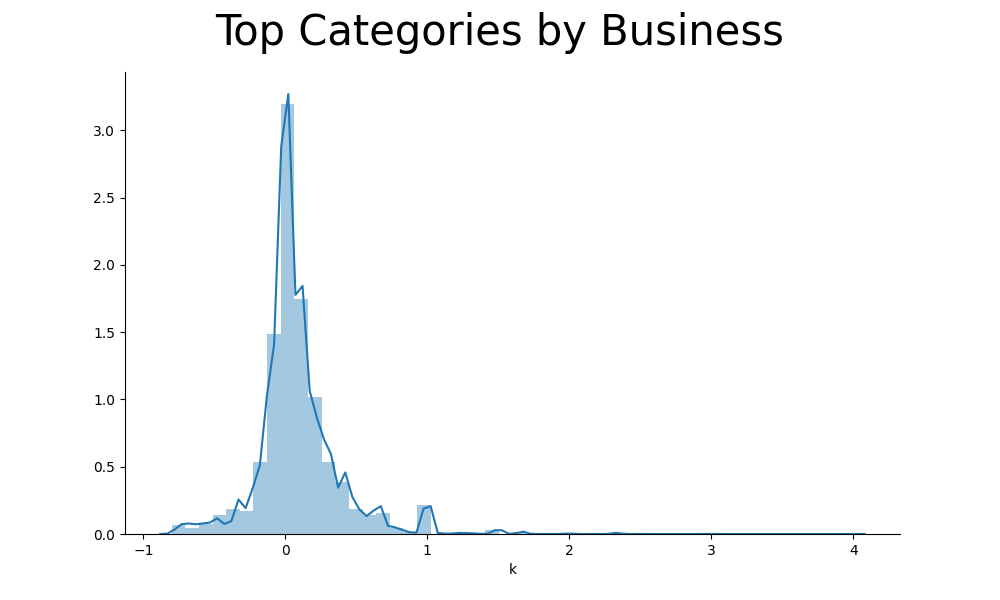

In [34]:
elite_skew_pd=elite_skew.toPandas()
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(elite_skew_pd['skew'],ax=ax)
plt.suptitle('Top Categories by Business',fontsize=30)
sns.despine()
plt.xlabel("k")
%matplot plt


From the graph above, compare with the previous graph for users who write reviews. We can see that the elite skew graph has more centralized trendline which means the histogram is more centered at 0. It means the rating that was provided by elites is more closed to actual ratings.